# [TIC 307210830](https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC307210830TCE1)

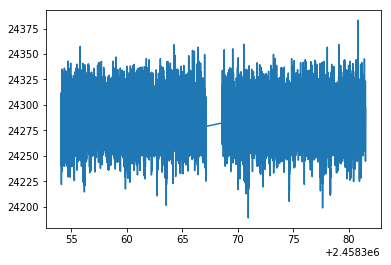

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import astropy.units as u
from glob import glob

paths = glob('307210830/*.fits')

lc = fits.getdata(paths[0])

time, flux = lc['TIME'][~np.isnan(lc['PDCSAP_FLUX'])], lc['PDCSAP_FLUX'][~np.isnan(lc['PDCSAP_FLUX'])]

time += 2457000
plt.plot(time, flux)

In [26]:
from scipy.stats import binned_statistic
from toolkit import LightCurve, concatenate_light_curves

lc = LightCurve(times=time, fluxes=flux)

In [27]:
from astropy.constants import G, M_sun, R_sun
import astropy.units as u

def period_to_a(params, M_star=.305*M_sun, R_star=.317*R_sun): 
    return (((G * M_star / (4 * np.pi**2) * (params.per * u.day)**2)**(1/3)) / R_star).decompose().value

In [57]:
from batman import TransitParams, TransitModel

paramsb = TransitParams()
paramsb.per = 2.253014
paramsb.t0 = 2458354.906208
paramsb.duration = 1/24
paramsb.rp = np.sqrt(571.225532 * 1e-6)
paramsb.a  = period_to_a(paramsb)
paramsb.u = [0.5971, 0.1172]
paramsb.limb_dark = 'quadratic'
paramsb.w = 90
paramsb.inc = 90
paramsb.ecc = 0

paramsc = TransitParams()
paramsc.per = 3.690613
paramsc.inc = 90
paramsc.t0 = 2458356.203764
paramsc.duration = 1/24
paramsc.rp = np.sqrt(1828.769675 * 1e-6)
paramsc.a = period_to_a(paramsc)
paramsc.u = [0.5971, 0.1172]
paramsc.limb_dark = 'quadratic'
paramsc.w = 90
paramsc.ecc = 0

paramsd = TransitParams()
paramsd.per = 7.451113
paramsd.inc = 89
paramsd.t0 = 2458355.2864
paramsd.duration = 1/24
paramsd.rp = np.sqrt(1641.527815 * 1e-6)
paramsd.a = period_to_a(paramsd)
paramsd.u = [0.5971, 0.1172]
paramsd.limb_dark = 'quadratic'
paramsd.w = 90
paramsd.ecc = 0

In [29]:
# Skip partial transits
transitsb = LightCurve(**lc.mask_out_of_transit(paramsb, oot_duration_fraction=2)
                      ).get_transit_light_curves(paramsb)[:-1]
transitsc = LightCurve(**lc.mask_out_of_transit(paramsc, oot_duration_fraction=2)
                      ).get_transit_light_curves(paramsc)[1:]
transitsd = LightCurve(**lc.mask_out_of_transit(paramsd, oot_duration_fraction=2)
                      ).get_transit_light_curves(paramsd)[1:]

In [30]:
import emcee
from copy import deepcopy
from corner import corner
import celerite
from celerite import terms, modeling

Initial log likelihood: -653.5425622098421


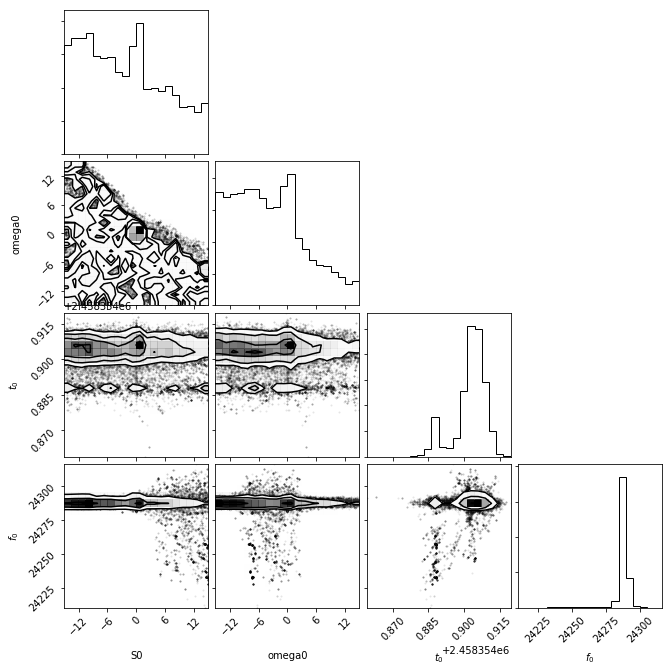

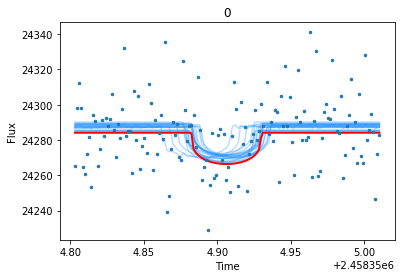

Initial log likelihood: -636.4817836996355


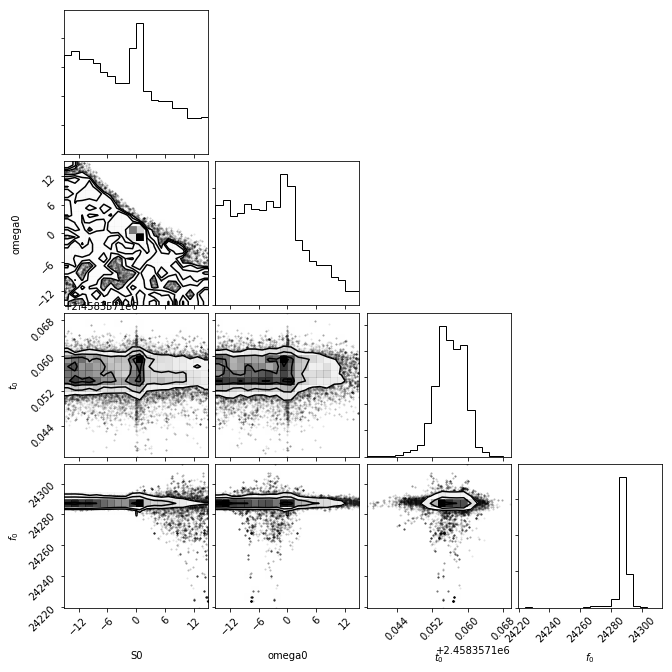

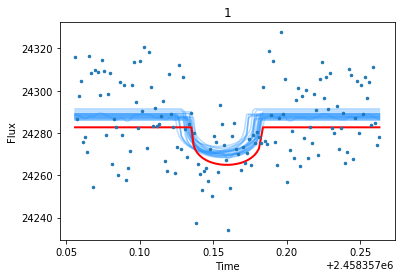

Initial log likelihood: -653.3224509503805


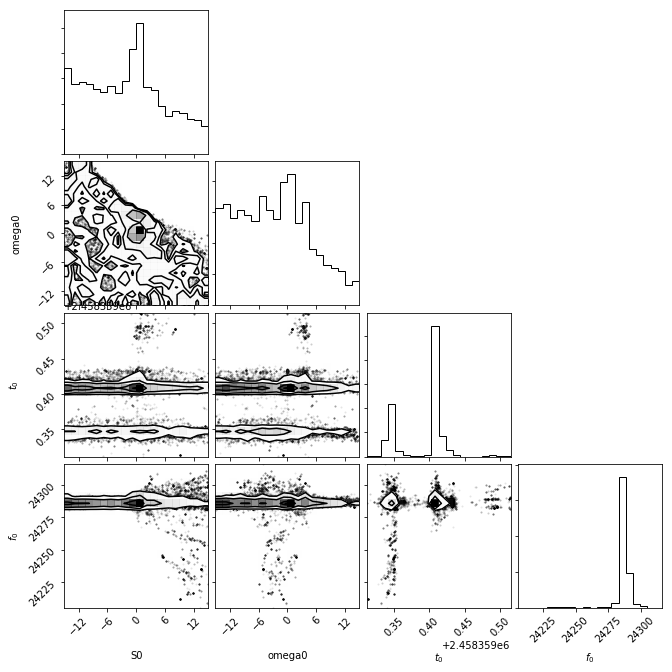

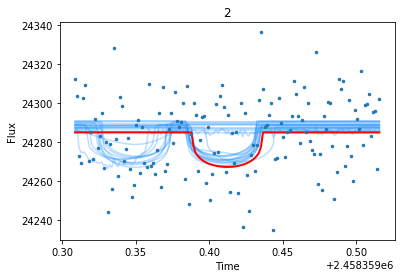

Initial log likelihood: -599.1799025006803


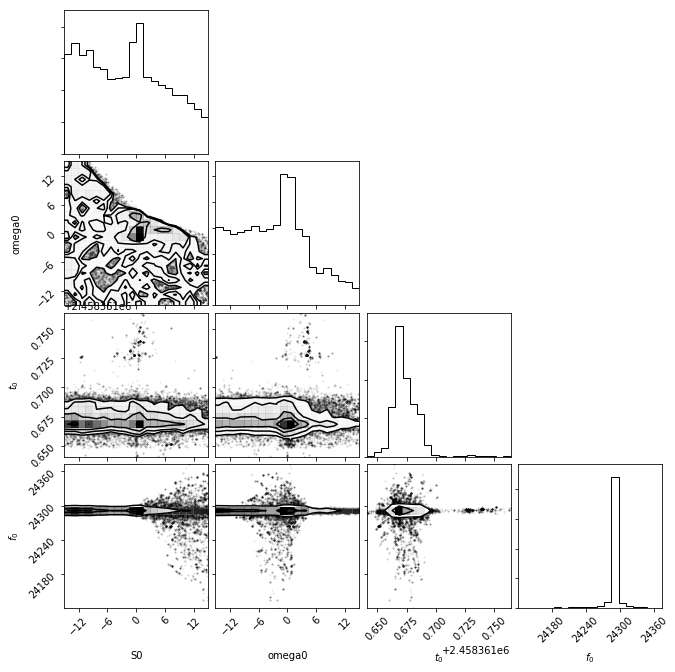

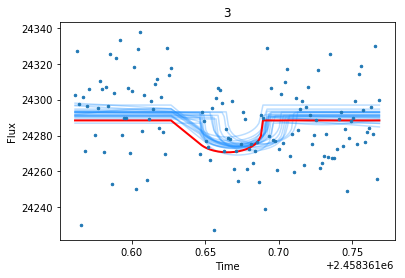

Initial log likelihood: -653.8398861187844


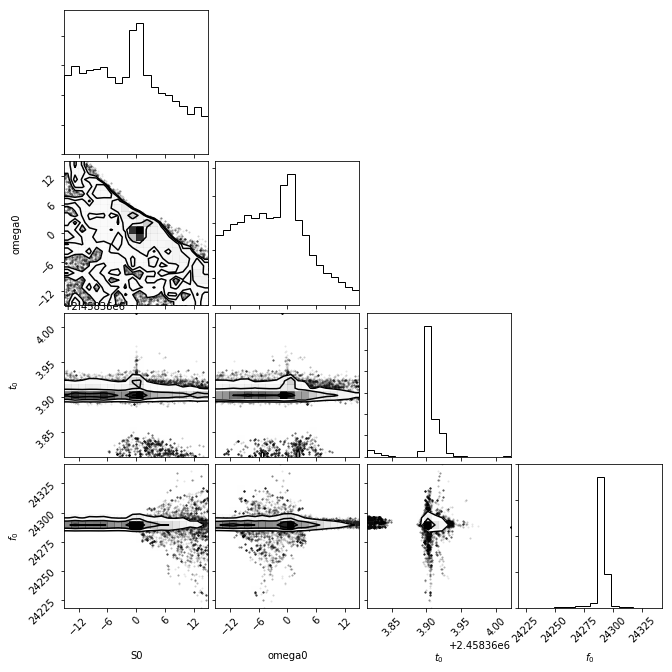

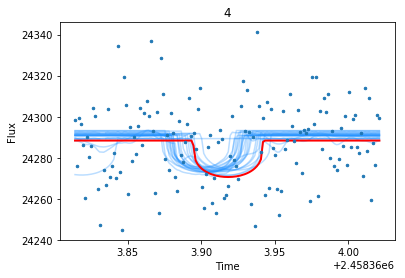

Initial log likelihood: -651.8781948032297


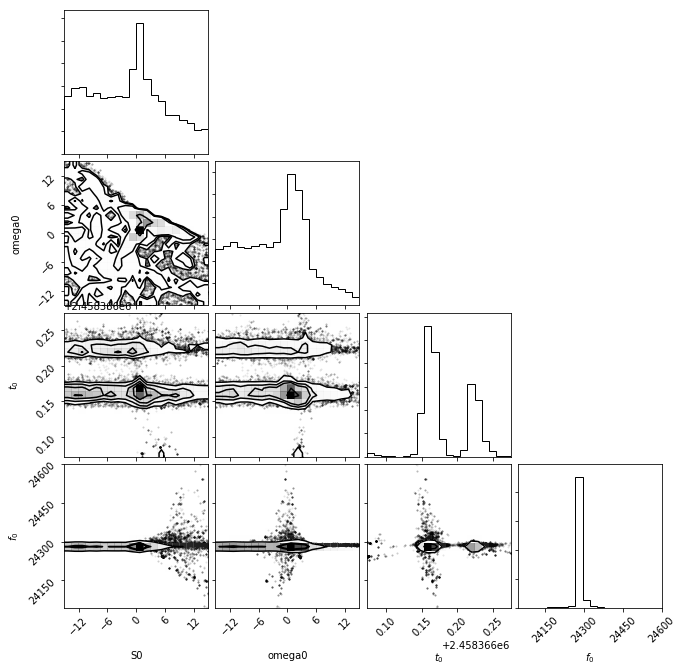

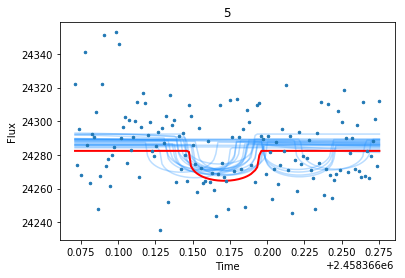

Initial log likelihood: -632.1730453663943


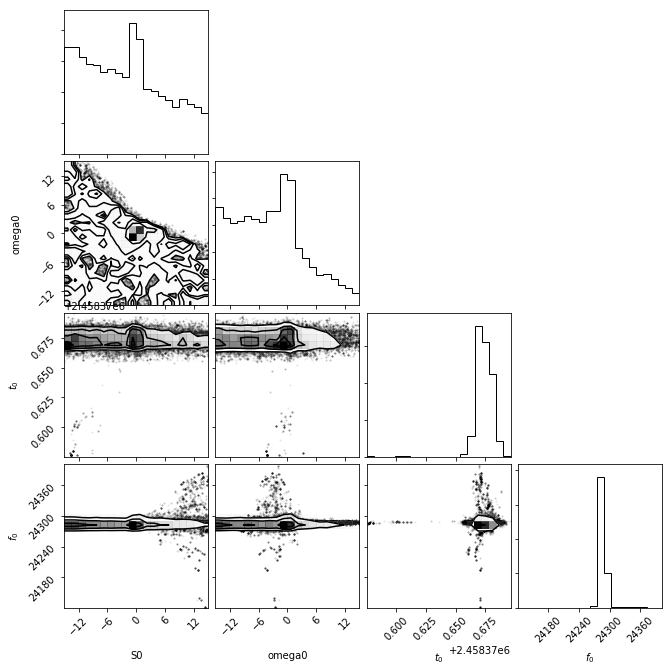

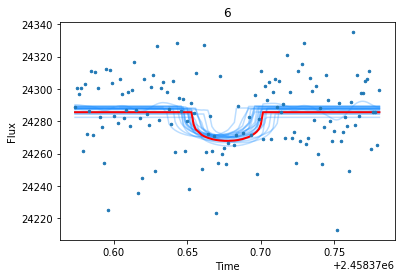

Initial log likelihood: -653.087201958807


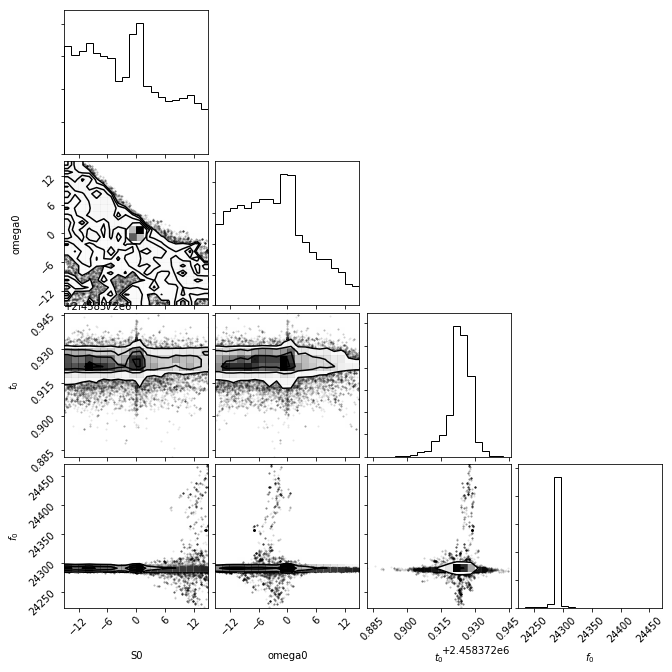

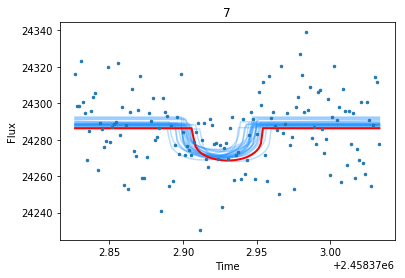

Initial log likelihood: -657.8895480885491


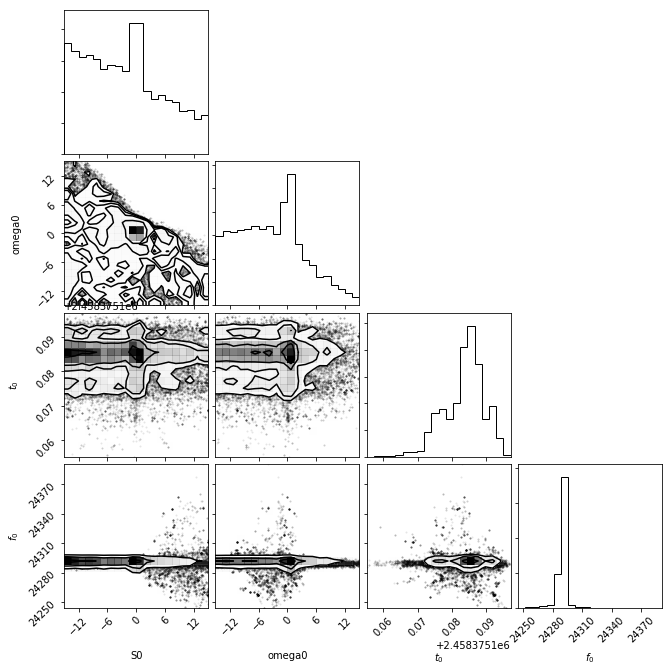

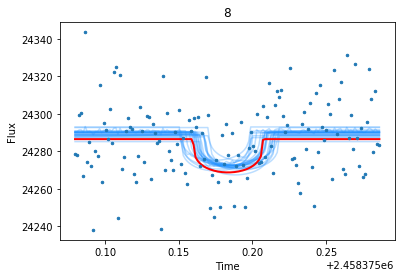

Initial log likelihood: -655.8215860347791


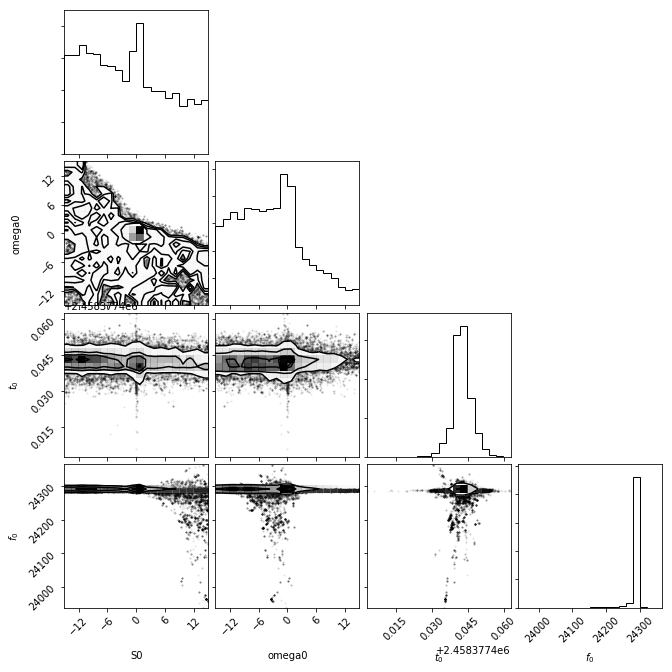

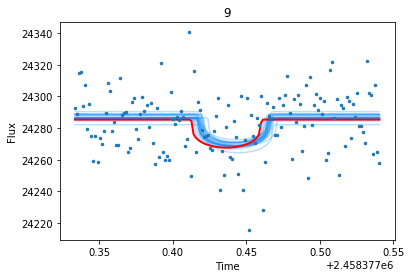

In [76]:
transit_times_b = []


class MeanModel(modeling.Model):
    parameter_names = ("t0", "f0")

    def get_value(self, t):
        params = deepcopy(paramsb)
        params.t0 = self.t0
        m = TransitModel(params, t)
        model = self.f0*m.light_curve(params) 
        return model


for transit in transitsb:    
    x, y, yerr = transit.times.jd, transit.fluxes, np.std(transit.fluxes)
    # A non-periodic component
    Q = 1.0 / np.sqrt(2.0)
    w0 = 3.0
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                           bounds=bounds)
    kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

    mean_model = MeanModel(t0=np.mean(x), f0=np.median(y))
    gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
    gp.compute(x, yerr)  # You always need to call compute once.
    print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
    
    def log_probability(params):
        gp.set_parameter_vector(params)
        lp = gp.log_prior()
        if not np.isfinite(lp) or params[2] < transit.times.jd.min() or params[2] > transit.times.jd.max():
            return -np.inf
        return gp.log_likelihood(y) + lp
    
    ndim, nwalkers = 4, 50
    
    initp = [np.array([0, 0, transit.times.jd.mean(), np.median(transit.fluxes)]) + 
             np.concatenate([1e-3 * np.random.randn(3), [1*np.random.randn()]]) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)
    sampler.run_mcmc(initp, 10000)
    sampler.reset()
    sampler.run_mcmc(initp, 1000)
    
    corner(sampler.flatchain, labels=["S0", "omega0", "$t_0$", "$f_0$"])
    plt.show()
    
    transit_times_b.append([np.median(sampler.flatchain[:, 2]), 
                            np.std(sampler.flatchain[:, 2])])

    m = TransitModel(paramsb, transit.times.jd)
    model = m.light_curve(paramsb)

    for s in sampler.flatchain[np.random.randint(sampler.flatchain.shape[0], size=24)]:
        gp.set_parameter_vector(s)
        mu = gp.predict(y, x, return_cov=False)
        plt.plot(x, mu, color='DodgerBlue', alpha=0.3)
    plt.plot(transit.times.jd, model * np.median(transit.fluxes), lw=2, color='r')    
    transit.plot(plot_kwargs=dict(ms=5, marker='.', lw=0))
        
    plt.show()

    sampler.pool.close()

Initial log likelihood: -662.7445297635214


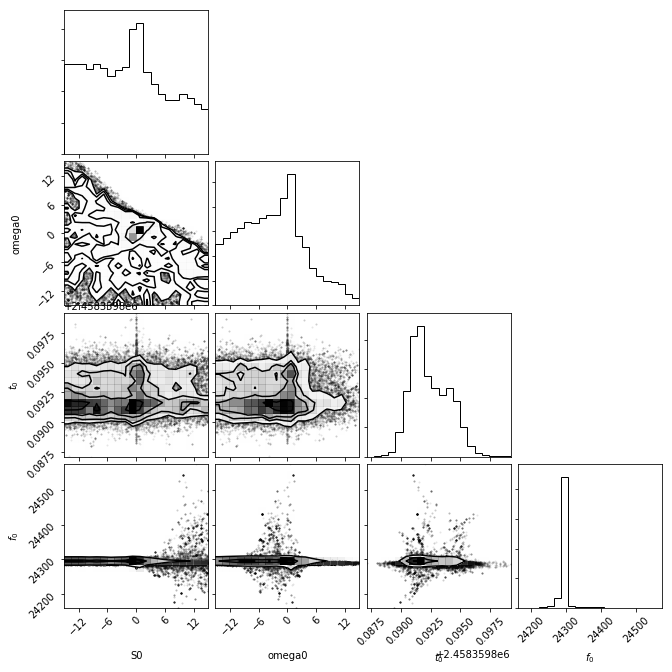

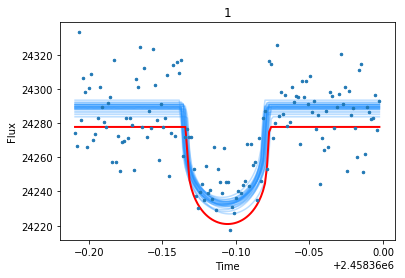

Initial log likelihood: -643.8501586072214


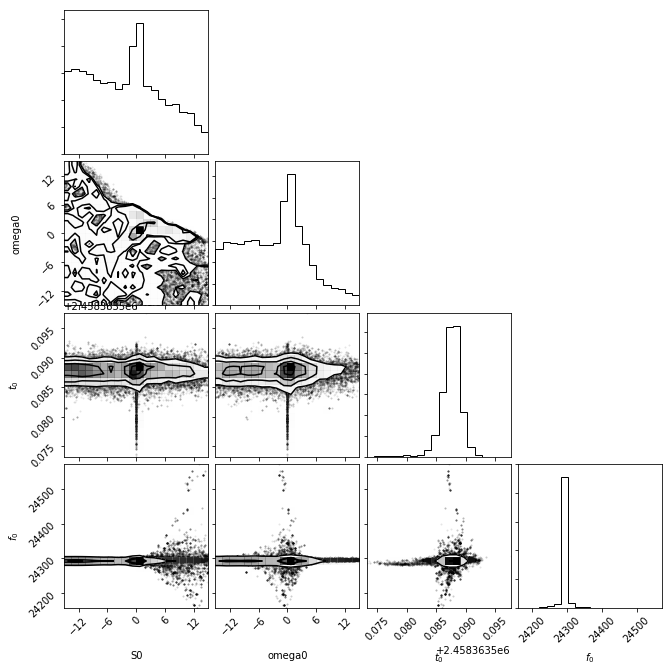

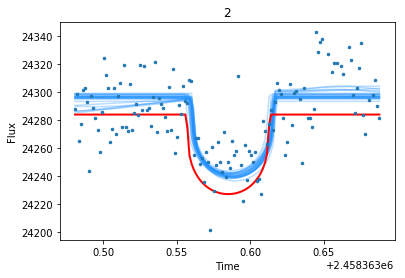

Initial log likelihood: -667.0640945468941


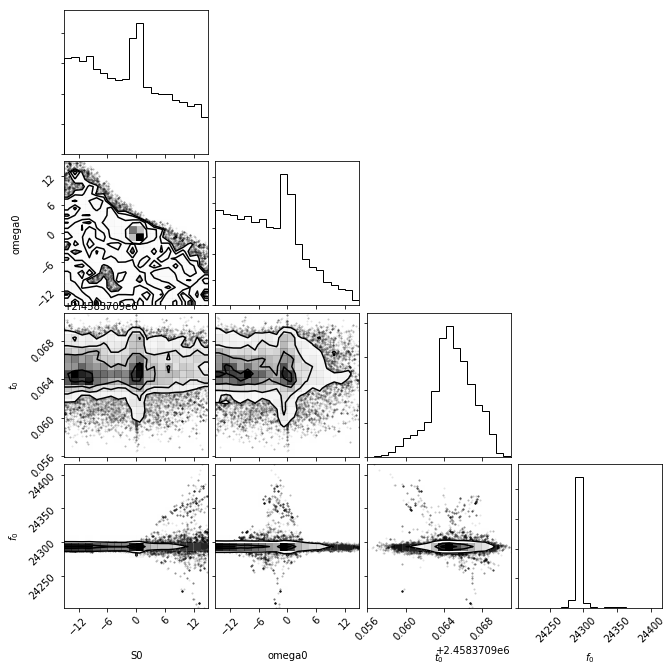

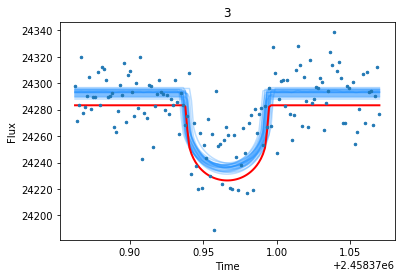

Initial log likelihood: -659.5439121848508


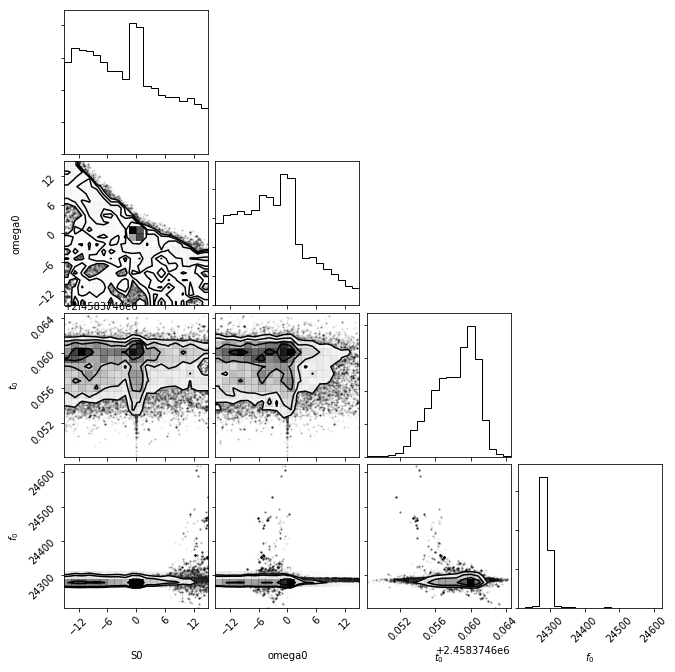

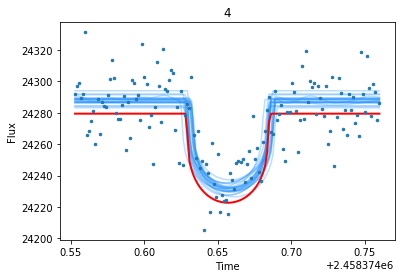

Initial log likelihood: -663.8088234883104


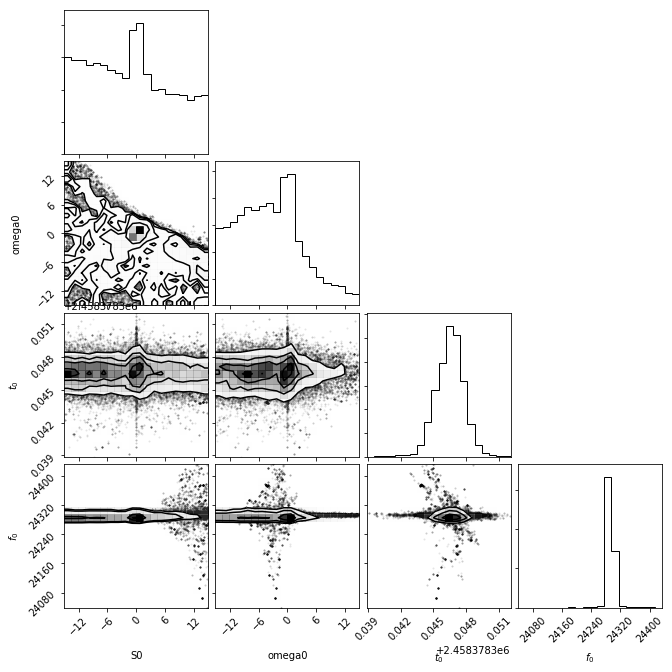

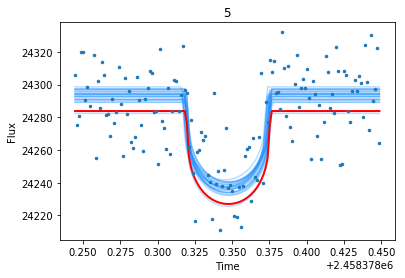

In [77]:
transit_times_c = []


class MeanModel(modeling.Model):
    parameter_names = ("t0", "f0")

    def get_value(self, t):
        params = deepcopy(paramsc)
        params.t0 = self.t0
        m = TransitModel(params, t)
        model = self.f0*m.light_curve(params) 
        return model


for transit in transitsc:    
    x, y, yerr = transit.times.jd, transit.fluxes, np.std(transit.fluxes)
    # A non-periodic component
    Q = 1.0 / np.sqrt(2.0)
    w0 = 3.0
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                           bounds=bounds)
    kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

    mean_model = MeanModel(t0=np.mean(x), f0=np.median(y))
    gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
    gp.compute(x, yerr)  # You always need to call compute once.
    print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
    
    def log_probability(params):
        gp.set_parameter_vector(params)
        lp = gp.log_prior()
        if not np.isfinite(lp):
            return -np.inf
        return gp.log_likelihood(y) + lp
    
    ndim, nwalkers = 4, 50
    
    initp = [np.array([0, 0, transit.times.jd.mean(), np.median(transit.fluxes)]) + 
             np.concatenate([1e-3 * np.random.randn(3), [1*np.random.randn()]]) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)
    sampler.run_mcmc(initp, 10000)
    sampler.reset()
    sampler.run_mcmc(initp, 1000)
    
    corner(sampler.flatchain, labels=["S0", "omega0", "$t_0$", "$f_0$"])
    plt.show()
    
    transit_times_c.append([np.median(sampler.flatchain[:, 2]), 
                            np.std(sampler.flatchain[:, 2])])

    m = TransitModel(paramsb, transit.times.jd)
    model = m.light_curve(paramsc)

    for s in sampler.flatchain[np.random.randint(sampler.flatchain.shape[0], size=24)]:
        gp.set_parameter_vector(s)
        mu = gp.predict(y, x, return_cov=False)
        plt.plot(x, mu, color='DodgerBlue', alpha=0.3)
    plt.plot(transit.times.jd, model * np.median(transit.fluxes), lw=2, color='r')    
    transit.plot(plot_kwargs=dict(ms=5, marker='.', lw=0))
        
    plt.show()

    sampler.pool.close()

Initial log likelihood: -669.1151991352862


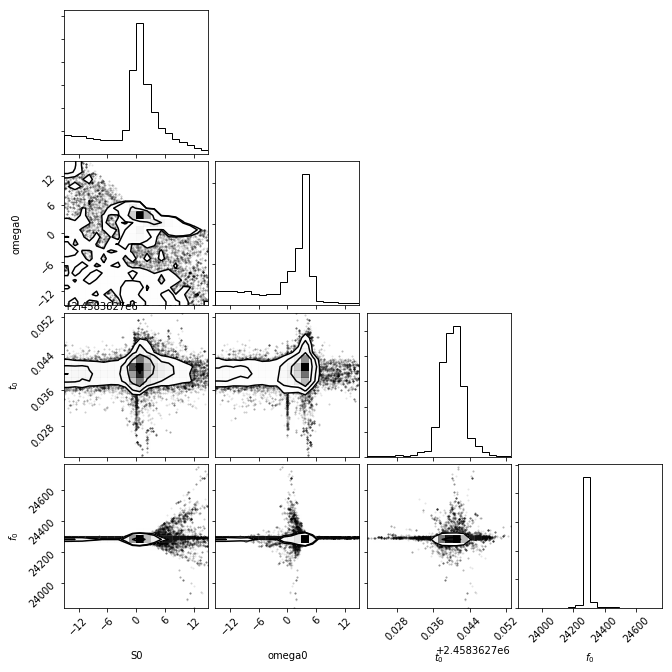

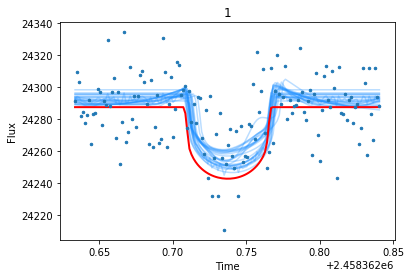

Initial log likelihood: -662.4136897538036


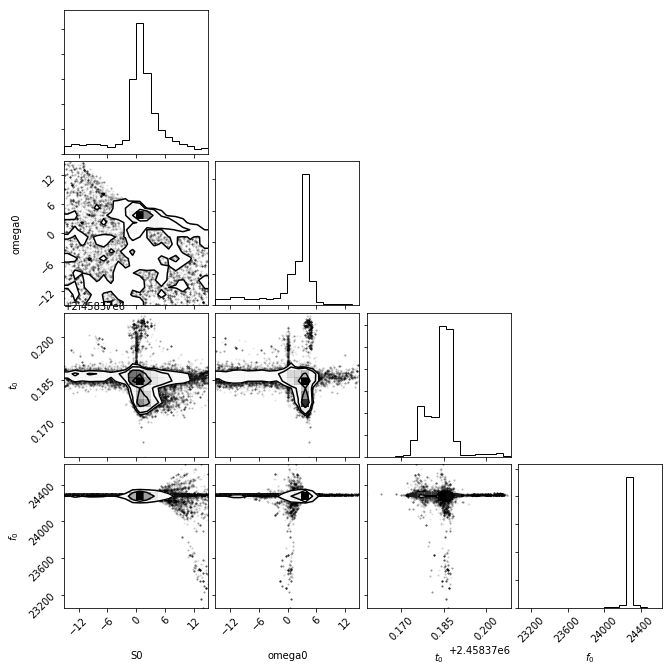

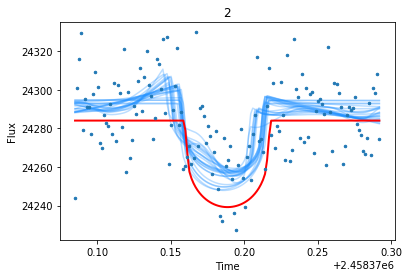

Initial log likelihood: -691.5144278894646


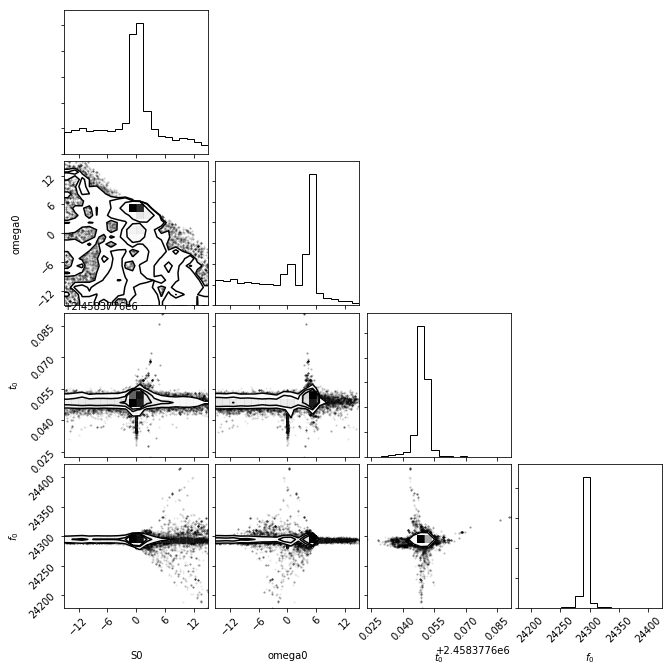

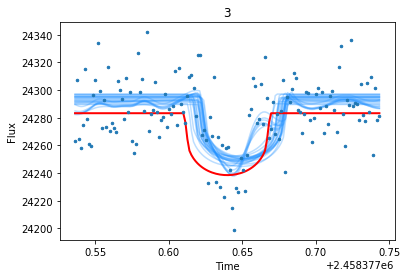

In [78]:
transit_times_d = []


class MeanModel(modeling.Model):
    parameter_names = ("t0", "f0")

    def get_value(self, t):
        params = deepcopy(paramsd)
        params.t0 = self.t0
        m = TransitModel(params, t)
        model = self.f0*m.light_curve(params) 
        return model


for transit in transitsd:    
    x, y, yerr = transit.times.jd, transit.fluxes, np.std(transit.fluxes)
    # A non-periodic component
    Q = 1.0 / np.sqrt(2.0)
    w0 = 3.0
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                           bounds=bounds)
    kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

    mean_model = MeanModel(t0=np.mean(x), f0=np.median(y))
    gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
    gp.compute(x, yerr)  # You always need to call compute once.
    print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
    
    def log_probability(params):
        gp.set_parameter_vector(params)
        lp = gp.log_prior()
        if not np.isfinite(lp) or params[2] < transit.times.jd.min() or params[2] > transit.times.jd.max():
            return -np.inf
        return gp.log_likelihood(y) + lp
    
    ndim, nwalkers = 4, 50
    
    initp = [np.array([0, 0, transit.times.jd.mean(), np.median(transit.fluxes)]) + 
             np.concatenate([1e-3 * np.random.randn(3), [1*np.random.randn()]]) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)
    sampler.run_mcmc(initp, 10000)
    sampler.reset()
    sampler.run_mcmc(initp, 1000)
    
    corner(sampler.flatchain, labels=["S0", "omega0", "$t_0$", "$f_0$"])
    plt.show()
    
    transit_times_d.append([np.median(sampler.flatchain[:, 2]), 
                            np.std(sampler.flatchain[:, 2])])

    m = TransitModel(paramsb, transit.times.jd)
    model = m.light_curve(paramsd)

    for s in sampler.flatchain[np.random.randint(sampler.flatchain.shape[0], size=24)]:
        gp.set_parameter_vector(s)
        mu = gp.predict(y, x, return_cov=False)
        plt.plot(x, mu, color='DodgerBlue', alpha=0.3)
    plt.plot(transit.times.jd, model * np.median(transit.fluxes), lw=2, color='r')    
    transit.plot(plot_kwargs=dict(ms=5, marker='.', lw=0))
        
    plt.show()

    sampler.pool.close()

Text(0,0.5,'O-C [min]')

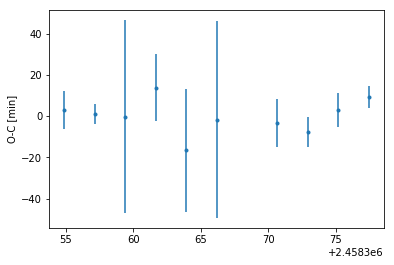

In [79]:
btimes = np.array(transit_times_b)[:, 0]
berrs = np.array(transit_times_b)[:, 1]

bepoch = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10]
fit = np.polyval(np.polyfit(bepoch, btimes, 1), bepoch)

plt.errorbar(btimes, 24 * 60 * (btimes-fit), 24 * 60 * berrs, fmt='.')
#plt.ylim([-30, 30])
plt.ylabel('O-C [min]')

Text(0,0.5,'O-C [min]')

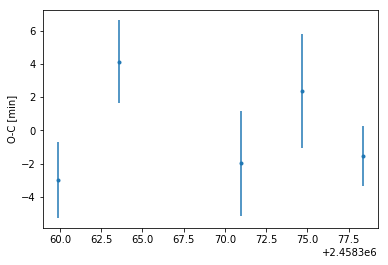

In [80]:
ctimes = np.array(transit_times_c)[:, 0]
cerrs = np.array(transit_times_c)[:, 1]

cepoch = [0, 1, 3, 4, 5]
fit = np.polyval(np.polyfit(cepoch, ctimes, 1), cepoch)

plt.errorbar(ctimes, 24*60*(ctimes-fit), 24*60*cerrs, fmt='.')
plt.ylabel('O-C [min]')

Text(0,0.5,'O-C [min]')

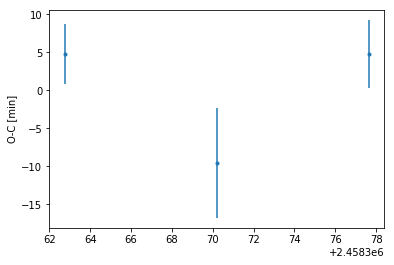

In [81]:
dtimes = np.array(transit_times_d)[:, 0]
derrs = np.array(transit_times_d)[:, 1]

fit = np.polyval(np.polyfit(np.arange(len(dtimes)), dtimes, 1), np.arange(len(dtimes)))

plt.errorbar(dtimes, 24 * 60 * (dtimes-fit), 24 * 60 * derrs, fmt='.')
plt.ylabel('O-C [min]')

In [82]:
np.save('307210830/transit_times_b.npy', np.vstack(transit_times_b).T)
np.save('307210830/transit_times_c.npy', np.vstack(transit_times_c).T)
np.save('307210830/transit_times_d.npy', np.vstack(transit_times_d).T)